In [1]:
from itertools import combinations

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from unidecode import unidecode
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from itertools import combinations
from datetime import datetime
from contextlib import contextmanager

In [2]:
df_train = pd.read_csv("../../data/kalapa/train.csv")
df_test = pd.read_csv("../../data/kalapa/test.csv")

/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def check_duplicate(feature1, feature2):
    check1 = list(df_train[feature1].fillna("NaN"))
    check2 = list(df_train[feature2].fillna("NaN"))
    return check1 == check2
distinct_columns = {}
for col1 in df_test.columns:
    vc = df_train[col1].value_counts()
    index = [len(vc), set(list(vc)), set(list(vc.index))]
    for col2 in distinct_columns:
        if index == distinct_columns[col2] and check_duplicate(col1, col2):
            break
    else:
        distinct_columns[col1] = index

In [4]:
DROP = ["gioiTinh","info_social_sex", "diaChi", 'currentLocationCity', 'currentLocationName',\
        'homeTownCity', 'homeTownName', "Field_68", "Field_49", "Field_48", "Field_46", "Field_45", "Field_45", \
       "Field_56", "Field_61"]
DATE = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 34, 35, 40]]
DATETIME = ["Field_{}".format(i) for i in [1, 2, 43, 44]]

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
def subtract_date(date1,date2, df):
    df[date1] = pd.to_datetime(df[date1], infer_datetime_format=True)
    df[date2] = pd.to_datetime(df[date2], infer_datetime_format=True)
    df[date1+date2] = (df[date2] - df[date1]).dt.days

In [7]:
def process_ngaySinh(s):
    if s != s:
        return np.nan
    try:
        s = int(s)
    except ValueError:
        s = s.split(" ")[0]
        
    return datetime.strptime(str(s)[:6], "%Y%m")

In [8]:
def datetime_normalize(s):
    if s != s:
        return np.nan
    
    s = s.split(".")[0]
    if s[-1] == "Z":
        s = s[:-1]
        
    date, time = s.split("T")
    datetime_obj = datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj

In [9]:
def date_normalize(s):
    if s != s:
        return np.nan
    
    try:
        datetime_obj = datetime.strptime(s, "%m/%d/%Y")
    except:
        datetime_obj = datetime.strptime(s, "%Y-%m-%d")
        
    return datetime_obj

In [10]:
def process_datetime_cols(df):
    cat_cols = []
    for col in DATETIME:
        df[col] = df[col].apply(datetime_normalize)
        
    for col in DATE:
        if col == "Field_34":
            continue
        df[col] = df[col].apply(date_normalize)

    df["Field_34"] = df["Field_34"].apply(process_ngaySinh)
    df["ngaySinh"] = df["ngaySinh"].apply(process_ngaySinh)
    
    cat_cols += DATE + DATETIME
    for col in DATE + DATETIME:
        df[col] = df[col].dt.strftime('%d-%m-%Y')
    
    subtract_date('Field_5','Field_6',df)
    subtrac_List = ['Field_1', 'Field_2', 'Field_43', 'Field_44', 'Field_7','Field_8', 'Field_9']
    subtract_2C = list(combinations(subtrac_List, 2))
    for l in subtract_2C:
        subtract_date(l[0],l[1],df)
    
    for cat in ['F', 'E', 'C', 'G', 'A']:
        subtract_date(f'{cat}_startDate', f'{cat}_endDate', df)
    print(df.shape) 
    return df

In [11]:
def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

In [12]:
def process_location(df):
    for col in ["currentLocationLocationId", "homeTownLocationId", "currentLocationLatitude", "currentLocationLongitude", 
                   "homeTownLatitude", "homeTownLongitude"]:
        df[col].replace(0, np.nan, inplace=True)
    return df

In [13]:
def combine_gender(s):
    x, y = s
    return x if x != None else y if y != None else None

In [14]:
def process_gender(df):
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1).astype("category")
    return df

In [15]:
def process_ordinal(df):        
    df["subscriberCount"].replace(0, np.nan, inplace=True)
    df["friendCount"].replace(0, np.nan, inplace=True)
    
    df["Field_13"] = df["Field_13"].apply(lambda x: 1 if x == x else 0)
    df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
    df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
    
    df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
    df["Field_28"] = df["Field_28"].replace({0.0: np.nan})
        
    for col in df.columns:
        if df[col].dtype.name == "object":
            df[col] = df[col].apply(str_normalize).astype("category")
            
    return df

In [16]:
def fix_maCv(x):
    lower = str(x).lower()
    if any([x in lower for x in ["nhân viên", "kế toán", "thủ kho", "tạp vụ",\
                                "thu ngân", "phóng viên", "giao dịch", "operator", "cnv",\
                                "huấn luyện viên", "ktoán", "nv", "lễ tân", "thư ký ",\
                                "gsbh", "tiếp viên", "nhõn viờn", "chăm sóc", "hướng dẫn viên", \
                                "kiểm phẩm",  "kĩ sư",  "cấp dưỡng", "kiểm gấp",\
                                "kiểm soát viên", "kiểm ngân", "nv", "lưu hóa", "nhân  viên", "lưu trữ viên", \
                                "phát hành báo", "ktv", "kiến trúc sư", "kinh tế viên", "staff", "checker",\
                                "sỹ quan", "dịch vụ", "kiểm tra viên", \
                                "cộng tác viên", "qc ksqt", "nhân vên", "kế hoạch sản xuất", "nhaõn vieõn", \
                                "thí nghiệm", "thông kê", "kiểm hàng", "k? s?", "thư ký", "hợp đồng", \
                                "thẩm phán", "thao tác viên", "thủ quỹ", "lấy mẫu", "LÁI XE".lower(), \
                                "biên tập", "ksxd", "phiên dịch", "tb tuyên huấn", "sales", "thường trực", \
                                "trợ lý", "tiếp thực", "giỏm sỏt", \
                                "trình dược viên", "btđtn", "phúng viờn", \
                                "thông dịch", "tiếp thị", "tư vấn", "tổng đài", "vi tính", "viên chức", \
                                "văn phòng", "văn thư", 'Thiết Kế'.lower(), "vận hành", "nhan vien", \
                                "kiểm tra chất lượng", "pbt", "phi công", "laptop",\
                                "phụ trách kiểm hàng", "quay phim", "thư viện viên", \
                                "trực buồng", "techcombank", "cảng vụ viên", "trainee", "bhxh", "marketing", \
                                "tuyên truyền viên",  "kế hoạch", "ks", \
                                "an toàn viên", "CHỈ SỐ VIÊN".lower(), \
                                "thu mua", "giám éịnh viên", "kiểm định viên",  "giám định", \
                                "quản trị mạng", "thơợ", "thống kê", "thủ  quỹ",  \
                                "điện thoại", "điện thọai", "đội thông tin", "đón  tiếp khách hàng", \
                                "đơn hàng", "đại diện", "điều phối viên", "n.v", "bán vé", "c«ng nh©n", \
                                "gs camera",  "máy dán", "tv",  "đồ họa"]]):
        return "NV"
    elif any([x in lower for x in ["kỹ","chuyên viên","kĩ thuật viên","kĩ thuật", "kỹ thuật viên",\
                                 "kỷ thuật viên","lập trình viên", "chuyờn viờn", "chuyªn viªn",]]):
        return "KTV"
    elif any([x in lower for x in ["cán bộ", "cán sự", "bí thư đoàn", "cb", "phường đội", "trưởng công an", \
                                  "công an viên", "an ninh viên","tổ viên", "công chức", "quản sinh", \
                                   "bí thư xã  đoàn","điều tra viên", "đăng kiểm", "cỏn bộ","đtv", "trực ban",\
                                  ]]):
        return "CB"
    elif any([x in lower for x in ["tổ trưởng", "giám sát", "quản lý", "cửa hàng trưởng", "chuyền trưởng", "kho",\
                                  "phó", "pp", "nhóm trưởng", "trưởng phòng", "trưởng ca", "trưởng tàu khách", \
                                  "trưởng nhóm", "cửa hàng trưởng", "trưởng bộ", "tổng phụ trách", "đào tạo", \
                                  "phụ trách phòng", "quản doanh", "vhtt", "trưởng ban", "dự án", "nhân sự",\
                                  "chỉ huy", "triển khai", "trưởng kiểm soát", "điều hành", "đội trưởng", \
                                  "chỉ huy", "qlsx", "t? tr??ng", "may"]]):
        return "QL"
    elif any([x in lower for x in ["công",  "bảo vệ", "thợ", "lao động", "bán hàng",\
                                "phụ kho", "phụ việc", "phết", "bảo mẫu", "phục vụ", "đóng gói", "ép cao tần", \
                                "cn", "sản Phẩm", "giao nhận","cụng nhõn", "gia công", "kiÓm tra".lower(), \
                                "cô nuôi", "bảo dưỡng", "c.n", "coi bồn", "cạo mủ", "coõng nhaõn", "khai thác",\
                                "cod", "bốc xếp", "bếp", "lái máy", "lđpt", "khuôn", "hàng rong", "phụ bếp",\
                                "phụ tá", "thủ công", "dệt", "sửa chữa", "băng chuyền", "lắp ráp", \
                                "chà nhám", "cn", "bếp phụ", "chụp hình", "KHUNG SắT".lower(), "kcs chuyền", \
                                "lao động", "thành hình", "lao công", "cônh nhân", "thi công", "cán lần 1", \
                                "lái phụ máy", "thủy thủ", "gác ghi", "quay ghi", "bảo trì", "bảo mẩu", \
                                "máy 3 tàu", "giao hàng", "trực chính", "hỗ trợ", "lái xúc gạt", "công  nhân",\
                                "lđhđ", "lao d?ng", "c. nhân", "pv nước", "hđlđ", "vệ sinh", "phụ", "vệ sỹ", \
                                "xếp hộp", "barista", "hàn điện", "thuỷ thủ", "xây dựng", "b?o v?", \
                                "mài phá", "xếp da", "worker", "cong nhan", "pha chế", \
                                "máy trưởng", "phụ trách sản xuất", "trải vải", "YếN TIệC".lower(), "gấp xếp", \
                                "in sơ đồ", "lđ phổ thông", "mài", "nhồi mút", "ép", "gói", "đóng", \
                                "đội viên", "đánh máy", "đứng máy", "ủi", "săm", 'atlđ']]):
        return "CN"
    elif any([x in lower for x in ["lái xe", "tài xế", "phụ xe","lái cẩu", "vân hành", ]]):
        return "TX"
    elif any([x in lower for x in ["giáo viên", "gv", "giảng viên", "chủ nhiệm lớp", "giáo viến", \
                                   "Giáo viến".lower(), "mầm non"]]):
        return "GV"
    elif any([x in lower for x in ["kinh doanh", "kinh  doanh"]]):
        return "KD"

    elif any([x in lower for x in ["hiệu trưởng", "chủ tịch", "pgđ", "giám đốc"]]):
        return "GĐ"
    elif any([x in lower for x in ["điều dưỡng", "hộ lý", "nữ hộ sinh", "h? lý", "hộ sinh"]]):
        return "ĐD"
    elif any([x in lower for x in ["y sĩ", "dược sỹ", "bác sĩ", "bác sỹ", "dược", "dược tá", "thú y", "y sỹ",\
                                  "y tế", "y công", "y tá", "dựơc tá", "ytth"]]):
        return "BS"
    elif any([x in lower for x in ["cử nhân", "cđ", "học viên", "tc", "cao đẳng", "cao đẵng", "trung cấp"]]):
        return "HS"
    elif any([x in lower for x in ["diễn viên", "ca sĩ"]]):
        return "DV-CS"
    elif any([x in lower for x in ["undefined", "nguyễn thế hưng", "ln091", "thieu chuc danh", "th noọng hẹt", \
                                  "875 lk", "-", "p.xnk", "cỏn b?", '22568', "unt", "01019882", "xtnt", "ltv", \
                                  "plđg hc", "mia", "pqtd", "kttntl", "llqs", "kcsmhm", "nt", "dtm", "i", "qc",\
                                  '/  /', '1', '14', 'a', 'chủ hộ', 'coõng vuù', 'kcs', 'pk b2c',\
                                   'xt2', 'kcs', 'sxct']]):
        return np.nan
    return x

In [17]:
def fix_55(x):
    if x in ['BC', 'BG', 'CN', 'CO', 'DB', 'EL', 'FO', 'H5', 'KX', 'N7', 'NR', 'SD', 'SJ', 'ST', 'WD']:
        return np.nan
    return x

In [18]:
def transform(df):
    df = process_datetime_cols(df)
    df = process_gender(df)
    df = process_location(df)
    df = process_ordinal(df)
    return df.drop(DROP, 1)

In [19]:
df_train = pd.read_csv("../../data/kalapa/train.csv")
df_test = pd.read_csv("../../data/kalapa/test.csv")
df_all = df_train.drop(['label'], 1).append(df_test)
df_all = df_all[distinct_columns]

df_all.maCv = df_all.maCv.apply(fix_maCv)
df_all.Field_55 = df_all.Field_55.apply(fix_55)



with timer("Preprocess"):
    df_all_fe = transform(df_all.copy())
    df_all_fe['Age'] = df_all_fe.ngaySinh.apply(lambda x: 2020 - x.year)
    df_all_fe = df_all_fe.drop('ngaySinh', axis = 1)
    cols_select = [x for x in df_all_fe.columns if x not in DATE + DATETIME  + [f'{cat}_endDate' for cat in ['F', 'E', 'C', 'G', 'A']] + [f'{cat}_startDate' for cat in ['F', 'E', 'C', 'G', 'A']]]
    df_fe = df_all_fe[cols_select]
    df_fe.replace([np.inf, -np.inf], -99999999999999999, inplace=True)

    for col in df_fe.columns:
        if df_fe[col].dtype.name == "category":
            if df_fe[col].isnull().sum() > 0:
                df_fe[col] = df_fe[col].cat.add_categories(f'missing_{col}')
                df_fe[col].fillna(f'missing_{col}', inplace=True)
        else:
            df_fe[col].fillna(-99999, inplace=True)

    y_label = df_train["label"]
    train_fe = df_fe[df_fe["id"] < df_train.shape[0]]
    test_fe = df_fe[df_fe["id"] >= df_train.shape[0]]

(73411, 175)
Preprocess - done in 16s


/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/parker/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
cat = []
for col in train_fe.columns:
    if train_fe[col].dtype.name == "category":
        cat.append(col)
features = [col for col in train_fe.columns if col not in cat]
features

['id',
 'Field_3',
 'Field_10',
 'Field_13',
 'Field_19',
 'Field_20',
 'Field_21',
 'Field_22',
 'Field_23',
 'Field_27',
 'Field_28',
 'Field_29',
 'namSinh',
 'Field_38',
 'Field_39',
 'Field_41',
 'Field_42',
 'Field_47',
 'Field_50',
 'Field_51',
 'Field_53',
 'Field_58',
 'Field_59',
 'Field_60',
 'Field_62',
 'Field_63',
 'Field_64',
 'Field_67',
 'Field_69',
 'Field_70',
 'Field_71',
 'Field_72',
 'Field_73',
 'Field_74',
 'Field_75',
 'Field_76',
 'Field_77',
 'friendCount',
 'subscriberCount',
 'currentLocationLocationId',
 'currentLocationLatitude',
 'currentLocationLongitude',
 'homeTownLocationId',
 'homeTownLatitude',
 'homeTownLongitude',
 'topFriends',
 'numOrg',
 'F_numOrg',
 'F_numQuery',
 'E_numOrg',
 'E_numQuery',
 'C_numOrg',
 'C_numQuery',
 'G_numOrg',
 'G_numQuery',
 'A_numOrg',
 'A_numQuery',
 'summary_6m',
 'summary_3m',
 'summary_1m',
 'summary_1w',
 'partner0_A',
 'partner0_B',
 'partner0_C',
 'partner0_D',
 'partner0_E',
 'partner0_F',
 'partner0_G',
 'partn

In [22]:
X2 = train_fe[features]

[1.05308066e-01 3.84965602e-03 2.73259840e-03 6.33783390e-05
 2.60848305e-03 6.15678240e-03 4.33973051e-04 3.79429924e-04
 6.78236724e-03 1.18818880e-03 1.11993419e-03 5.30489778e-03
 2.35219014e-03 3.71058008e-03 1.19198529e-03 1.48954316e-03
 1.92062662e-03 6.20822664e-03 1.38557558e-04 8.18009441e-05
 4.35379323e-04 2.51925029e-03 5.08586079e-03 5.20127646e-03
 2.49513304e-03 6.23368572e-03 5.51155649e-03 6.87325927e-03
 6.04352121e-03 6.62555296e-03 6.45290967e-03 6.39700734e-03
 1.27977376e-02 2.37794754e-02 9.90134075e-03 9.33284235e-03
 9.98383346e-03 1.88044882e-02 7.30814283e-03 7.43884394e-03
 8.59744340e-03 9.00598540e-03 7.14747103e-03 8.11089936e-03
 7.52828913e-03 1.81557079e-02 2.22446379e-02 5.13910781e-03
 6.07805964e-03 6.46757141e-03 7.13597398e-03 2.88153277e-03
 4.46247408e-03 6.15009697e-03 6.60451803e-03 1.68848185e-02
 1.82904472e-02 1.94922762e-02 1.97582330e-02 2.06982534e-02
 1.89618379e-02 2.15688920e-03 2.48115847e-04 2.52697605e-03
 2.29151697e-03 1.797561

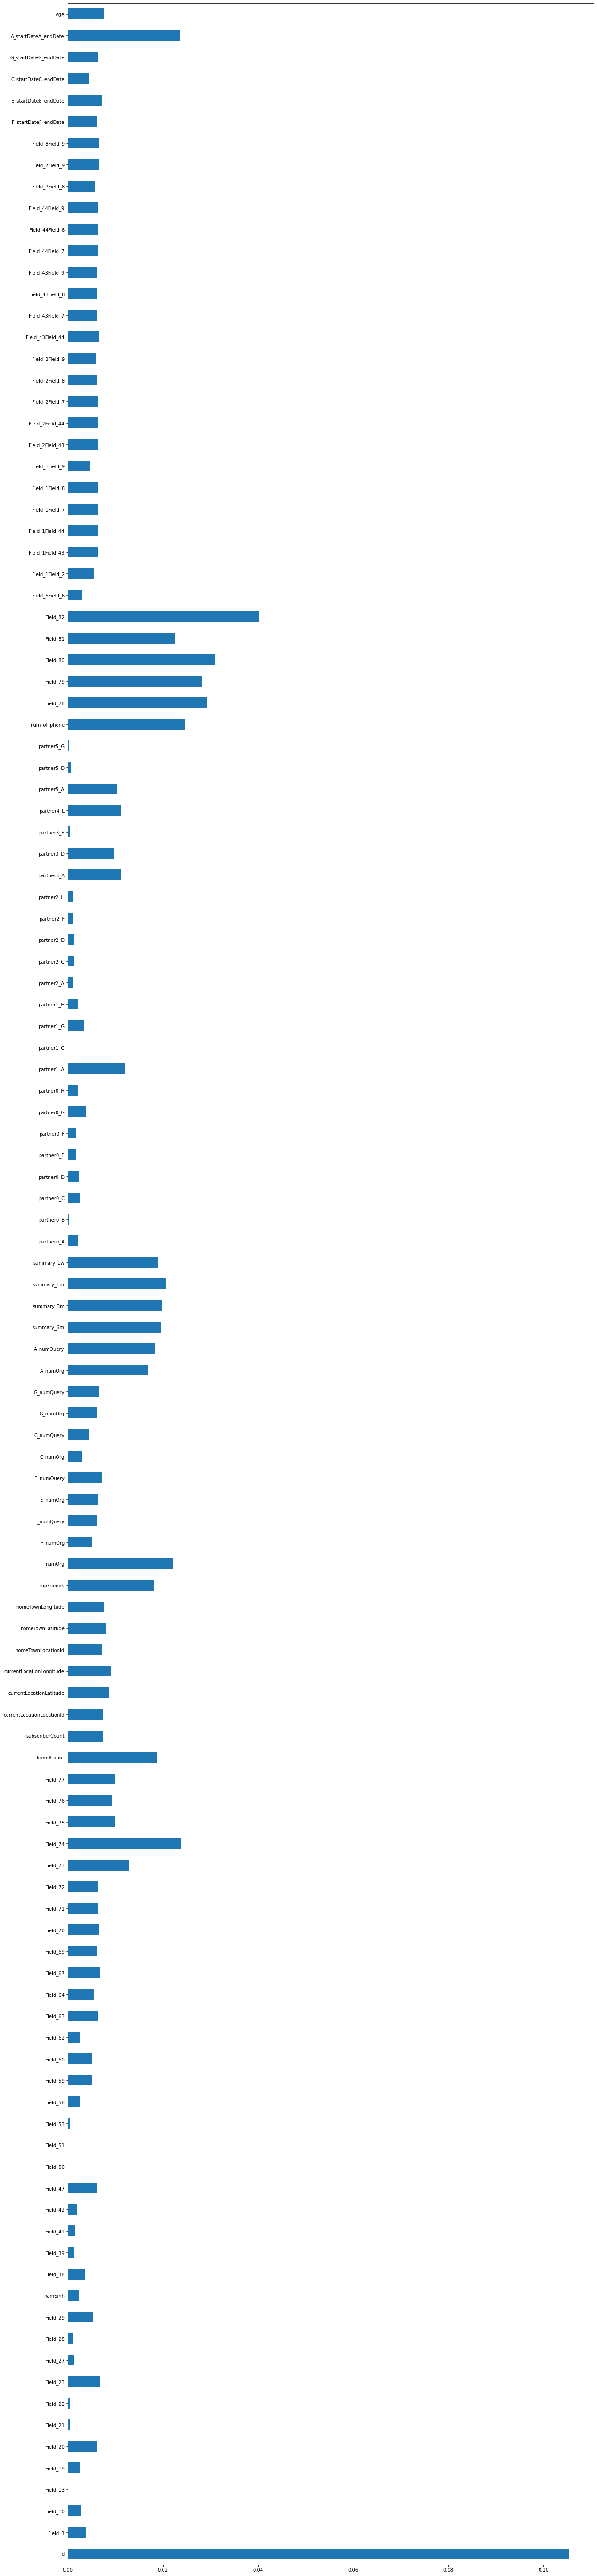

In [23]:
plt.figure(figsize=(20,100))
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X2,df_train.label)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X2.columns)
feat_importances.plot(kind='barh')
plt.show()

In [24]:
drop = ["Field_13","Field_22", "Field_21", "Field_50", "Field_51", "partner0_B",\
       "partner5_D", "partner5_G"]

In [25]:
df_train = pd.concat([df_train.id,df_train.label, train_fe.iloc[:,1:]], axis = 1)

In [26]:
df_train = df_train.drop(drop, axis = 1)
test_fe = test_fe.drop(drop, axis = 1)

In [27]:
data_version = "02-01-2021-v5"

In [28]:
os.makedirs(f"../../data/kalapa/{data_version}/", exist_ok=True)
df_train.to_csv(f"../../data/kalapa/{data_version}/train.csv", index = False)
test_fe.to_csv(f"../../data/kalapa/{data_version}/test.csv", index = False)